# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [366]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd
import collections, numpy
import math
from sklearn import metrics
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error, log_loss, )
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что  𝑥  - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    grad = np.empty(2, dtype=float)
    for i in range(2):
        grad[i] = 2*np.sin(w[i])*np.cos(w[i])
    return grad

In [5]:
grad_f(np.array([1, 2]))

array([ 0.90929743, -0.7568025 ])

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [8]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [9]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [10]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

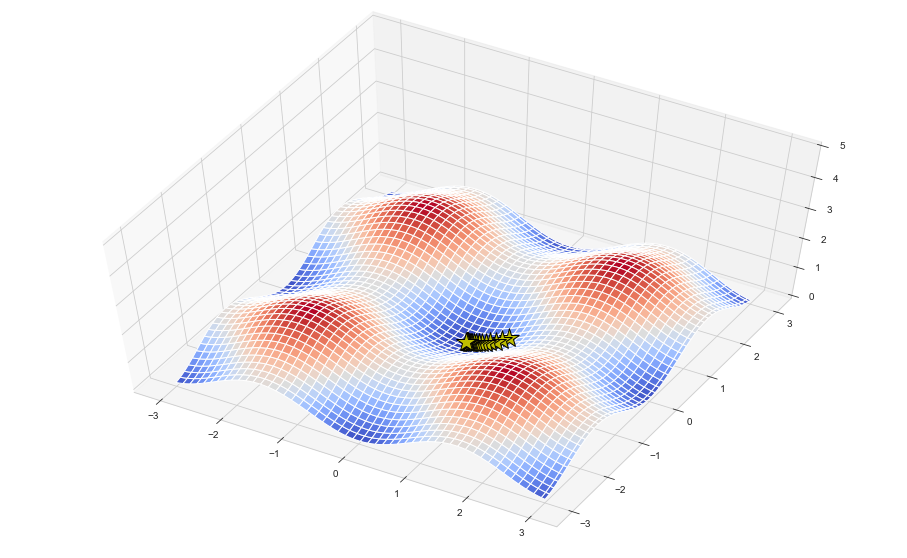

In [11]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

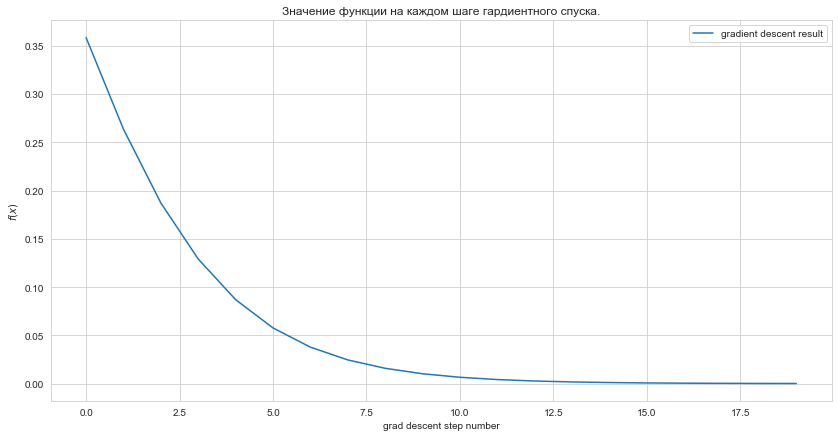

In [12]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перед началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [58]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    sum = 0
    N = len(y_true)
    for i in range(N):
        sum += (y_true[i] - y_pred[i]) ** 2
    MSE = (1 / N) * sum
    return MSE


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")


    X = X.transpose()
    N = len(y_true)
    MSE_grad = (2 / N) * (X @ (y_pred - y_true))
    return MSE_grad


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [31]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [14]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [33]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = X_test @ self.W
        return y_pred
        
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [34]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

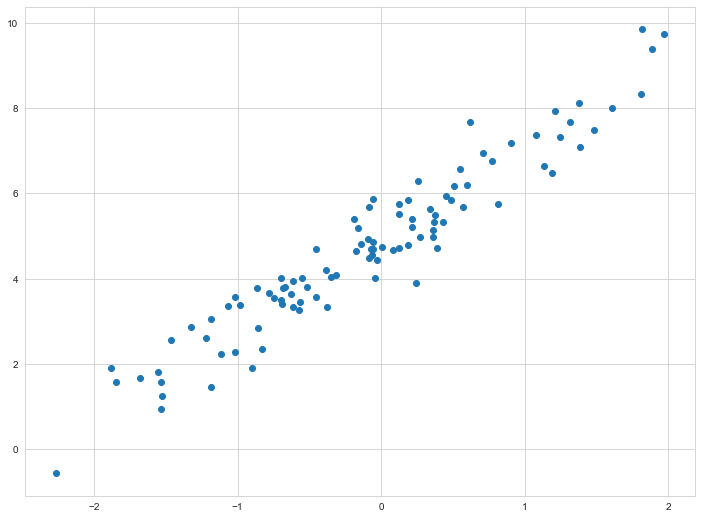

In [35]:
plt.scatter(X, y);

In [59]:
custom_lin_reg = CustomLinearRegression()

In [60]:
custom_lin_reg.fit(X, y)

My custom linear regression

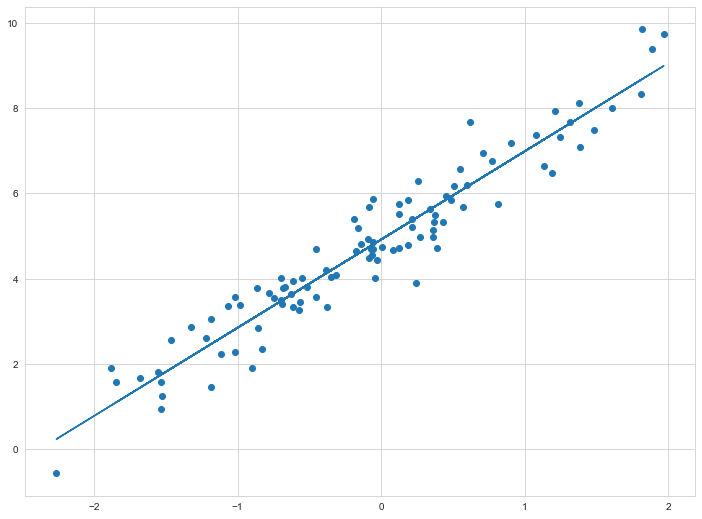

In [61]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Бостоне. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [111]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fu

Ваш ход:

In [68]:
X.shape

(506, 13)

In [139]:
X

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [73]:
y.shape

(506,)

In [66]:
feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [88]:
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Посмотрим, есть ли в датасете пропущенные значения

In [94]:
print(np.isnan(X).any().any())
print(np.isnan(y).any())

False
False


Посмотрим на распределение y

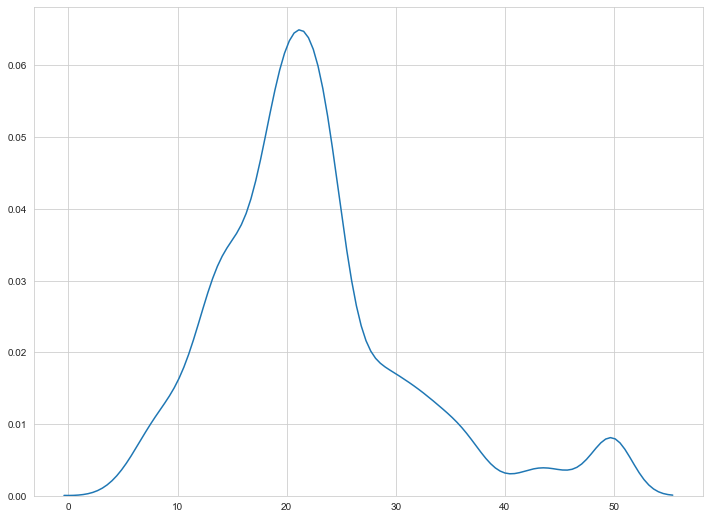

In [102]:
sns.kdeplot(y)

In [132]:
data_bost = pd.DataFrame(X, columns=feature_names)

In [133]:
data_bost

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [129]:
data_bost['MEDV'] = y

In [131]:
data_bost

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Сделаем стандартизацию значений признаков

In [135]:
s_scaler = StandardScaler()

In [137]:
X_trans = s_scaler.fit_transform(X)

In [138]:
X_trans

array([[-0.41978194,  0.28482986, -1.2879095 , ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236, -0.59338101, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236, -0.59338101, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.11573841, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.66905833]])

Поделим данные на тренировочную и тестовую выборки

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.1,
                                                    random_state=SEED)

In [142]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(455, 13)
(51, 13)
(455,)
(51,)


In [144]:
linregr_model = LinearRegression()
linregr_model.fit(X_train, y_train)

LinearRegression()

In [145]:
y_pred = linregr_model.predict(X_test)

In [146]:
r2_score(y_test, y_pred)

0.7283819547723692

In [147]:
mse(y_test, y_pred)

31.573422515927337

Посмотрим на значения коэффициентов линейной регрессии 

In [151]:
df_coef = pd.DataFrame(linregr_model.coef_ , feature_names)

In [152]:
df_coef

,0
CRIM,-0.806441
ZN,0.959374
INDUS,0.170654
CHAS,0.601560
NOX,-1.869004
RM,2.789966
AGE,-0.120523
DIS,-2.895646
RAD,2.277011
TAX,-1.882246


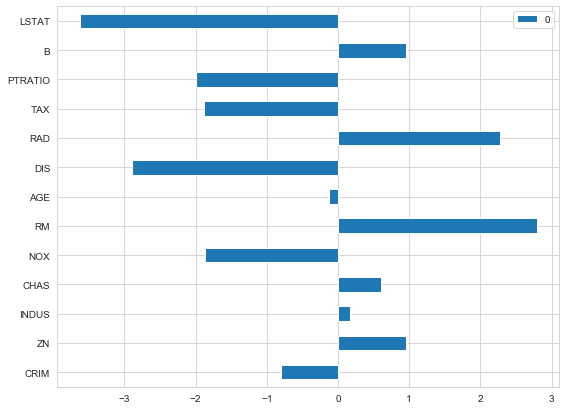

In [153]:
df_coef.plot(kind="barh", figsize=(9, 7))

Можно сделать вывод о том, что наибольший вклад в изменение признака вносят LSTAT и RM.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [160]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    
    sigm = 1 / (math.exp(-output) + 1)
    return sigm

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [273]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    sum = 0
    for i in range(n):
        sum += y_true[i] * np.log(y_pred[i]) + (1 - y_true[i]) * np.log(1 - y_pred[i])
    BCE = - (1 / n) * sum
    return BCE
        
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    X = X.transpose()
    BCE_grad = X @ (y_pred - y_true)
    return BCE_grad


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [280]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))

        y_pred = np.apply_along_axis(sigmoid, 1, X_test @ self.W).reshape(-1, 1)
        return y_pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [285]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

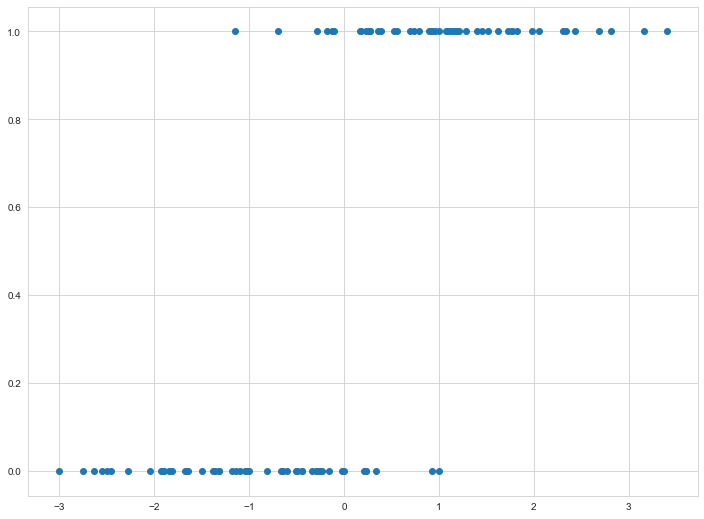

In [286]:
plt.scatter(X, y);

In [287]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

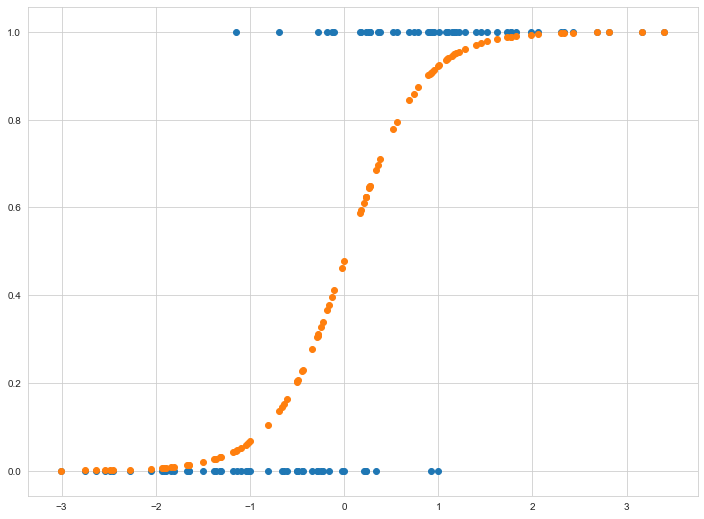

In [288]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [291]:
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)

In [292]:
fpr

array([0.  , 0.  , 0.  , 0.02, 0.02, 0.04, 0.04, 0.06, 0.06, 0.12, 0.12,
       0.16, 0.16, 0.18, 0.18, 0.24, 0.24, 0.44, 0.44, 0.56, 0.56, 1.  ])

In [293]:
tpr

array([0.  , 0.02, 0.52, 0.52, 0.56, 0.56, 0.74, 0.74, 0.84, 0.84, 0.88,
       0.88, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96, 0.98, 0.98, 1.  , 1.  ])

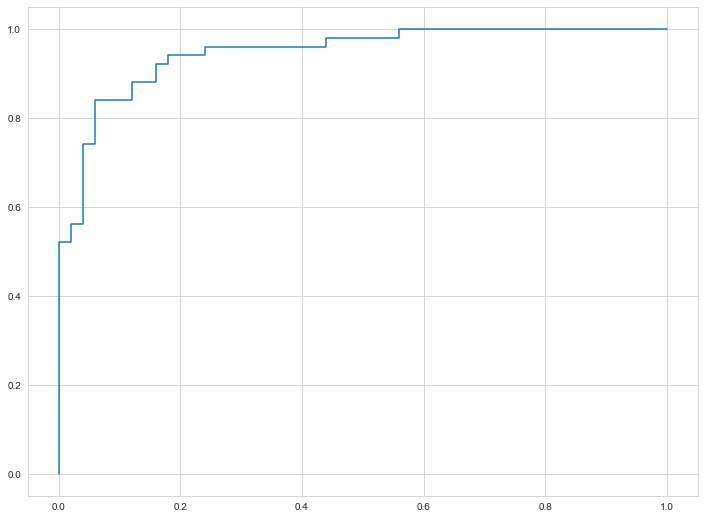

In [300]:
plt.plot(fpr, tpr)

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [301]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [306]:
pokemon.shape

(800, 13)

In [308]:
pokemon.dtypes

#              int64
Name          object
Type 1        object
Type 2        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

In [311]:
pokemon.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [409]:
pokemon['Legendary'] = pokemon['Legendary'].astype(int)

pokemon["Type 1"] = pokemon["Type 1"].astype('category')
pokemon["Type 2"] = pokemon["Type 2"].astype('category')
pokemon["Generation"] = pokemon["Generation"].astype('category')

Посмотрим на категориальные переменные

In [314]:
pokemon['Generation'].value_counts()

1    166
5    165
3    160
4    121
2    106
6     82
Name: Generation, dtype: int64

In [410]:
pokemon['Type 1'].value_counts()

Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Rock         44
Electric     44
Ground       32
Dragon       32
Ghost        32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: Type 1, dtype: int64

In [411]:
pokemon['Type 2'].value_counts()

Flying      97
Ground      35
Poison      34
Psychic     33
Fighting    26
Grass       25
Fairy       23
Steel       22
Dark        20
Dragon      18
Water       14
Ghost       14
Ice         14
Rock        14
Fire        12
Electric     6
Normal       4
Bug          3
Name: Type 2, dtype: int64

In [384]:
pokemon1 = pokemon.iloc[:, 5:11]

In [385]:
pokemon1

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,45,49,49,65,65,45
1,60,62,63,80,80,60
2,80,82,83,100,100,80
3,80,100,123,122,120,80
4,39,52,43,60,50,65
...,...,...,...,...,...,...
795,50,100,150,100,150,50
796,50,160,110,160,110,110
797,80,110,60,150,130,70
798,80,160,60,170,130,80


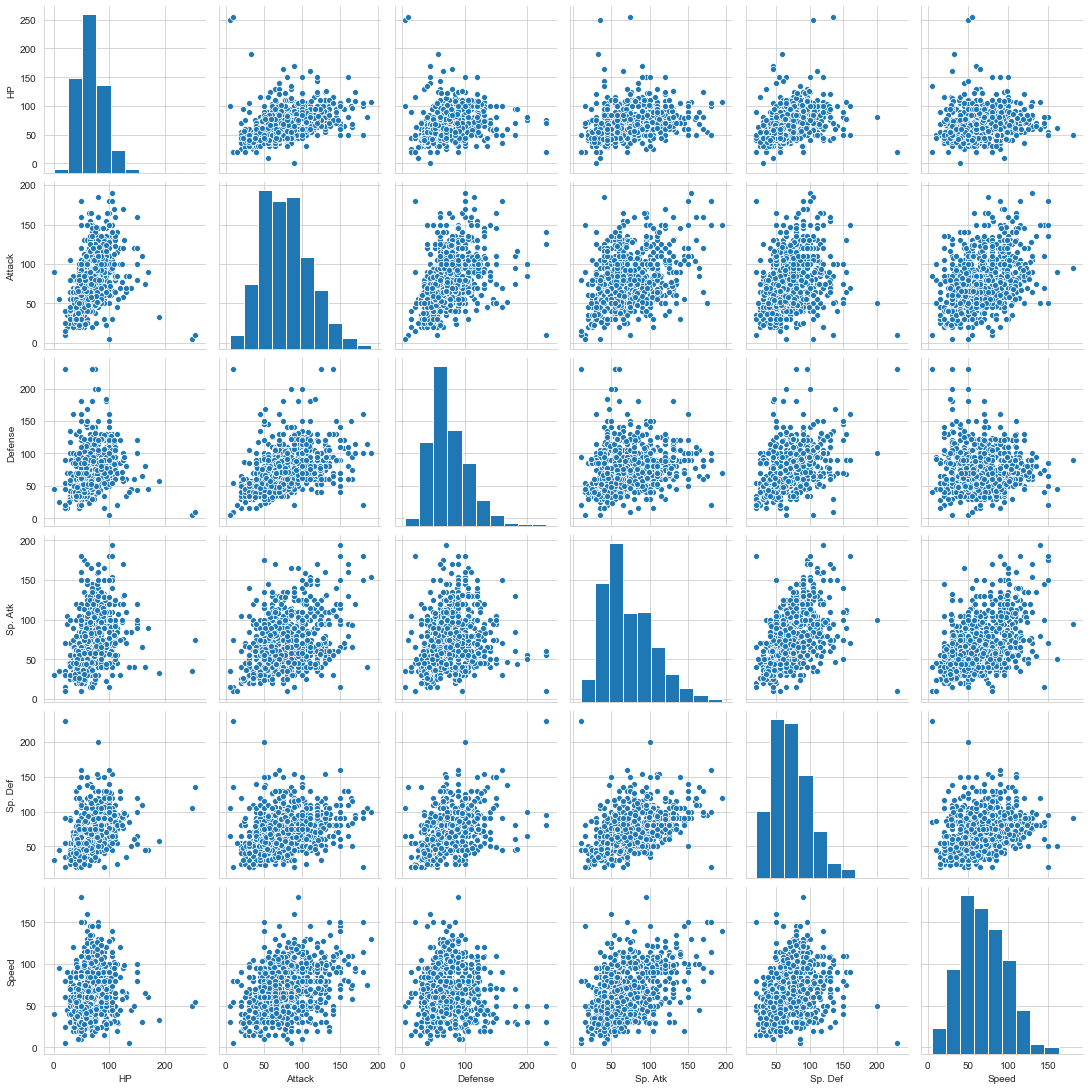

In [386]:
sns.pairplot(pokemon1)

Можно посмотреть на корреляцию переменных 

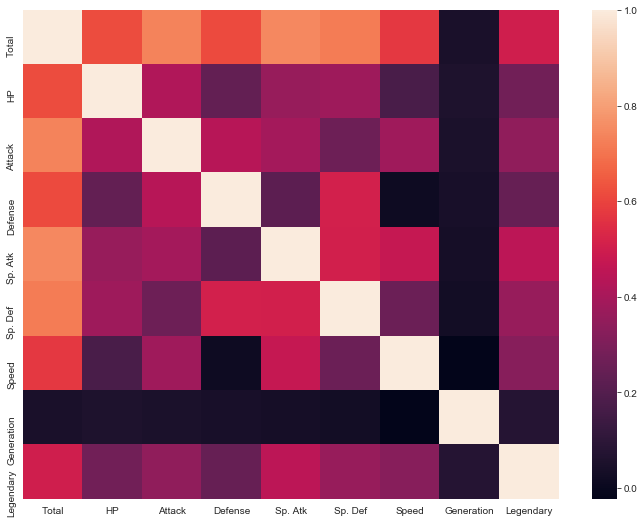

In [359]:
sns.heatmap(pokemon.iloc[:, 1:13].corr())

In [387]:
y = pokemon['Legendary']

In [388]:
X_train, X_test, y_train, y_test = train_test_split(pokemon1, y, test_size=0.2,
                                                    random_state=SEED)

In [389]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [390]:
y_pred = clf.predict(X_test)

In [391]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [393]:
clf.score(X_test, y_test)

0.91875

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


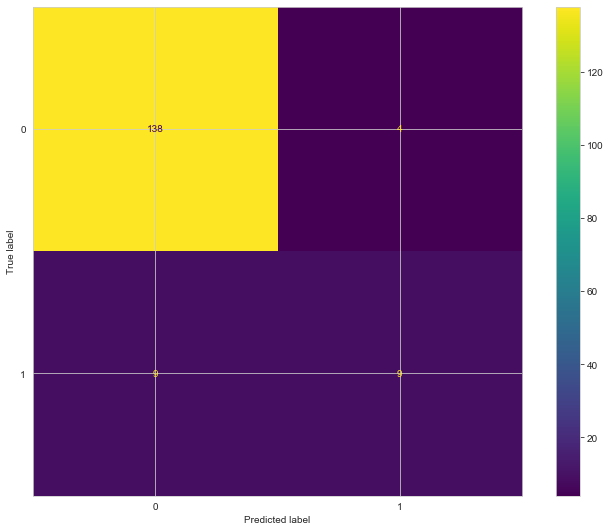

In [394]:
plot_confusion_matrix(clf, X_test, y_test) 

In [395]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

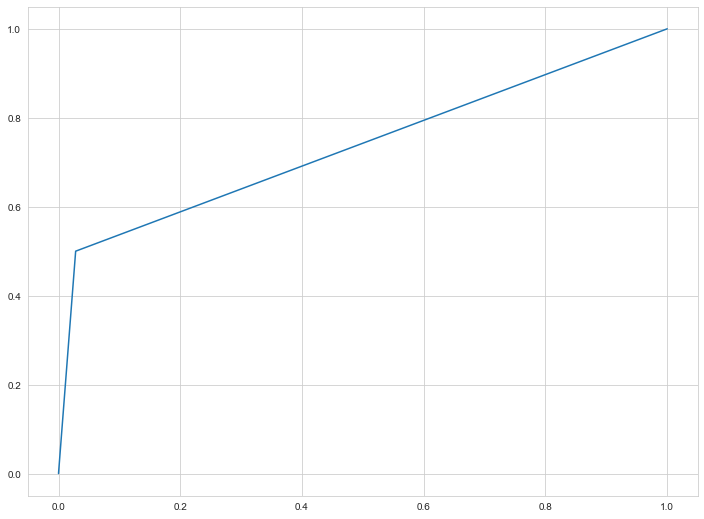

In [396]:
plt.plot(fpr, tpr)

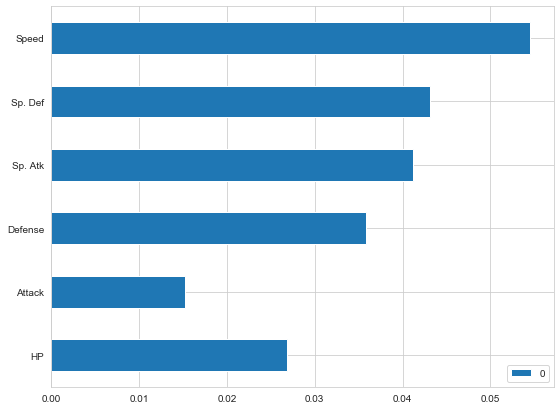

In [397]:
pd.DataFrame(clf.coef_.transpose(), index = pokemon1.columns).plot(kind="barh", figsize=(9, 7))

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Группа The Kills. Случайно попала на концерт, вообще про них не знала. Но они очень классные!

https://www.youtube.com/watch?v=498zUzNGQxY

https://www.youtube.com/watch?v=Sm1bDP0yNj8   